In [3]:
import cv2, skimage, pandas as pd, os, numpy as np, matplotlib.pyplot as plt, tensorflow as tf, time as t
from tensorflow import keras
from keras.models import load_model
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
from scipy import ndimage as ndi

In [116]:
%matplotlib inline

In [2]:
def load_image(path, size = [512,512]):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)  # auto handles jpg/png
    image = tf.image.resize(image, size)        # optional resize
    image = tf.cast(image, tf.float32) / 255.0        # normalize to [0, 1]
    return image

In [3]:
def weighted_binary_crossentropy(pos_weight, neg_weight):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        loss = - (pos_weight * y_true * tf.math.log(y_pred) +
                  neg_weight * (1 - y_true) * tf.math.log(1 - y_pred))
        return tf.reduce_mean(loss)
    return loss_fn

In [1]:
model = load_model("bce_pos_7_0_neg_1_0_elu_cy_well_3_4_only.keras", custom_objects = {'loss_fn': weighted_binary_crossentropy})

NameError: name 'load_model' is not defined

### Checking one

In [28]:
def seg_pipe(img: np.ndarray, p: np.ndarray):
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(np.uint8)
    p = p.astype(np.float32) # Convert to float32 as required by min_max_normalization

    p = cv2.normalize(p, None, 0, 255, cv2.NORM_MINMAX)
    p = p.astype(np.uint8)

    _, thresh = cv2.threshold(p,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 6)

    sure_bg = cv2.dilate(opening, kernel, iterations = 8)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

    _, sure_fg = cv2.threshold(dist_transform, 0.40*dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unk = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers += 10
    markers[unk == 255] = 0
    markers = cv2.watershed(img,markers)

    seg_img = skimage.color.label2rgb(markers, bg_label = 0)

    properties = ["label", "area", "centroid"]
    props = skimage.measure.regionprops_table(markers, intensity_image = img_grey, properties = properties)
    df = pd.DataFrame(props)
    
    return seg_img, df

In [62]:
ex_num = 500

In [63]:
seg_img, df = seg_pipe(images[ex_num], pred[ex_num]) # Load your images before running

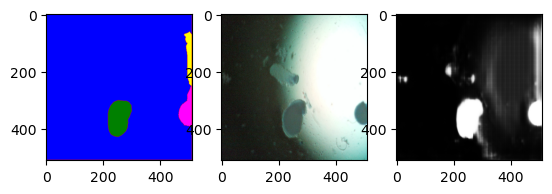

In [64]:
plt.subplot(1,3,1)
plt.imshow(seg_img)

plt.subplot(1,3,2)
plt.imshow(images[ex_num])

plt.subplot(1,3,3)
plt.imshow(pred[ex_num], cmap = "gray")

In [65]:
df_new = df[df["label"] != 10]

In [66]:
sum(df_new["area"]) / np.sum(pred[ex_num] > 0.5)

0.7094309174616735

###  Batch Segmentation

In [7]:
def weighted_binary_crossentropy(pos_weight, neg_weight):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        loss = - (pos_weight * y_true * tf.math.log(y_pred) +
                  neg_weight * (1 - y_true) * tf.math.log(1 - y_pred))
        return tf.reduce_mean(loss)
    return loss_fn

In [8]:
# model = load_model("bce_pos_7_0_neg_1_0_elu_cy.keras", custom_objects = {'loss_fn': weighted_binary_crossentropy})

In [9]:
model = load_model("bce_pos_7_0_neg_1_0_elu_cy_well_3_4_only.keras", custom_objects = {'loss_fn': weighted_binary_crossentropy})

I0000 00:00:1744254189.065347   51240 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1744254189.120083   51240 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1744254189.120140   51240 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1744254189.125800   51240 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1744254189.125843   51240 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [10]:
image_prefix = "Original_images/Processed/" # Change to your own
ip = [image_prefix + n for n in sorted(os.listdir(image_prefix))]
target_size = [512,512]

In [11]:
start_date, end_date = 19, 21
hour = [f"0{i}" for i in range(10)] + [str(i) for i in range(10,24)]
well_num = [2,3,4]

In [12]:
def date_dict(start_date, end_date, well_num):
    dct = dict()
    for d in range(start_date, end_date + 1):
        for h in hour:
            for w in well_num:
                dct[f"{d}_{h}_{w}"] = [[], []]
    return dct

In [13]:
# Loading for Tensorflow dataset
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)  # auto handles jpg/png
    image = tf.image.resize(image, target_size)        # optional resize
    image = tf.cast(image, tf.float32) / 255.0        # normalize to [0, 1]
    return image

# Loading for regular dataset
def load_images(paths):
    images = list()
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_COLOR)  # Loads BGR
        img = cv2.resize(img, target_size).astype(np.float32) # cast to float so float result is saved after /= operation
        img /= 255.0
        images.append(img)
    return np.stack(images)
 
def seg_pipe_batch(path):

    dct = date_dict(start_date, end_date, well_num)
    ip = [path + n for n in sorted(os.listdir(path))]

    dataset = tf.data.Dataset.from_tensor_slices(ip)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    pred = model.predict(dataset)
    images = load_images(ip)
    
    for img, p, fn in zip(images, pred, ip):

        s1 = fn.split("_")
        w, d, h = s1[2], s1[5].split("-")[-1], s1[6] # adjust based on file_path
        img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.astype(np.uint8)
        p = p.astype(np.float32) # Convert to float32 as required by min_max_normalization
    
        p = cv2.normalize(p, None, 0, 255, cv2.NORM_MINMAX)
        p = p.astype(np.uint8)
    
        _, thresh = cv2.threshold(p,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
        kernel = np.ones((3,3), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 6)
    
        sure_bg = cv2.dilate(opening, kernel, iterations = 8)
    
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    
        _, sure_fg = cv2.threshold(dist_transform, 0.40*dist_transform.max(), 255, 0)
    
        sure_fg = np.uint8(sure_fg)
        unk = cv2.subtract(sure_bg, sure_fg)
    
        _, markers = cv2.connectedComponents(sure_fg)
        markers += 10
        markers[unk == 255] = 0
        markers = cv2.watershed(img,markers)
    
        seg_img = skimage.color.label2rgb(markers, bg_label = 0)
    
        properties = ["label", "area", "centroid"]
        props = skimage.measure.regionprops_table(markers, intensity_image = img_grey, properties = properties)
        df = pd.DataFrame(props)
        df = df[df["label"] != 10] # Remove the area of background
        if df.shape[0]:
            mid = np.median(df["area"])
            df = df[df["area"] >= 0.1 * mid] # Removes detected region with area smaller than 10% median size (remove partially visible organoids)
            dct[f"{d}_{h}_{w}"][0].append(sum(df["area"]))
            dct[f"{d}_{h}_{w}"][1].append(df.shape[0])

    dct = {k:v for k,v in dct.items() if v and v[0]} # Remove the entries without any detected organoids
    
    return dct

In [14]:
all_dct = seg_pipe_batch("Original_images/Processed/")

2025-04-09 20:03:12.110199: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1744254192.130191   51446 service.cc:146] XLA service 0x7f16bc016ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744254192.131254   51446 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-04-09 20:03:12.299336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-09 20:03:12.341959: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
2025-04-09 20:03:19.617996: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[32,512,512,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,512,512,64]{3,2,1,0}, f

 3/41 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step 

I0000 00:00:1744254203.327159   51446 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step

2025-04-09 20:03:39.332280: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[22,512,512,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[22,512,512,64]{3,2,1,0}, f16[32,3,3,64]{3,2,1,0}, f16[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-04-09 20:03:41.038189: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.730532089s
Trying algorithm eng0{} for conv (f16[22,512,512,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[22,512,512,64]{3,2,1,0}, f16[32,3,3,64]{3,2,1,0}, f16[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_con

41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step


In [17]:
well_dct = dict()
for wn in well_num:
    well_dct[str(wn)] = dict()
for k,v in all_dct.items():
    d,h,w = k.split("_")
    well_dct[w][f"{d}_{h}"] = sum(v[0]) / sum(v[1])

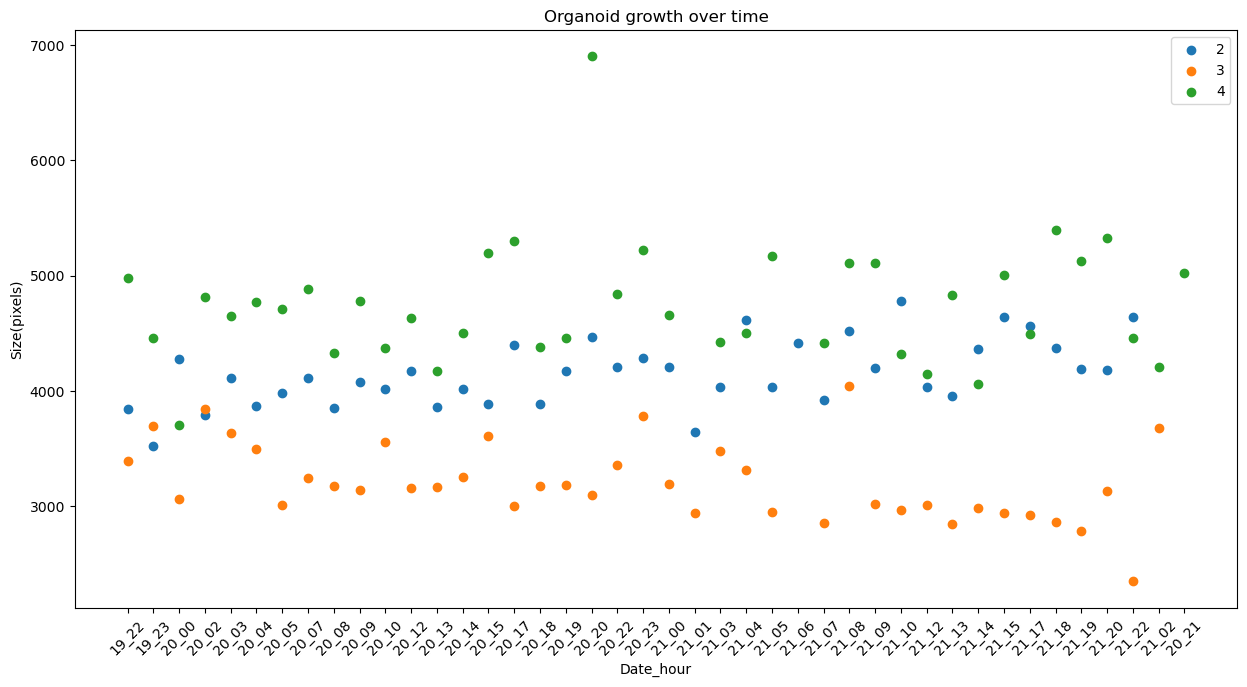

In [18]:
# Plotting 3 wells together since their lengths are equal
def plot_scatter_together(well_dct):
    plt.figure(figsize = (15,7.5))
    plt.title("Organoid growth over time")
    plt.xlabel("Date_hour")
    plt.ylabel("Size(pixels)")
    plt.xticks(rotation = 45)
    for k,v in well_dct.items():
        plt.scatter(list(v.keys()), list(v.values()), label = k)
    plt.legend()
    plt.show()

plot_scatter_together(well_dct)

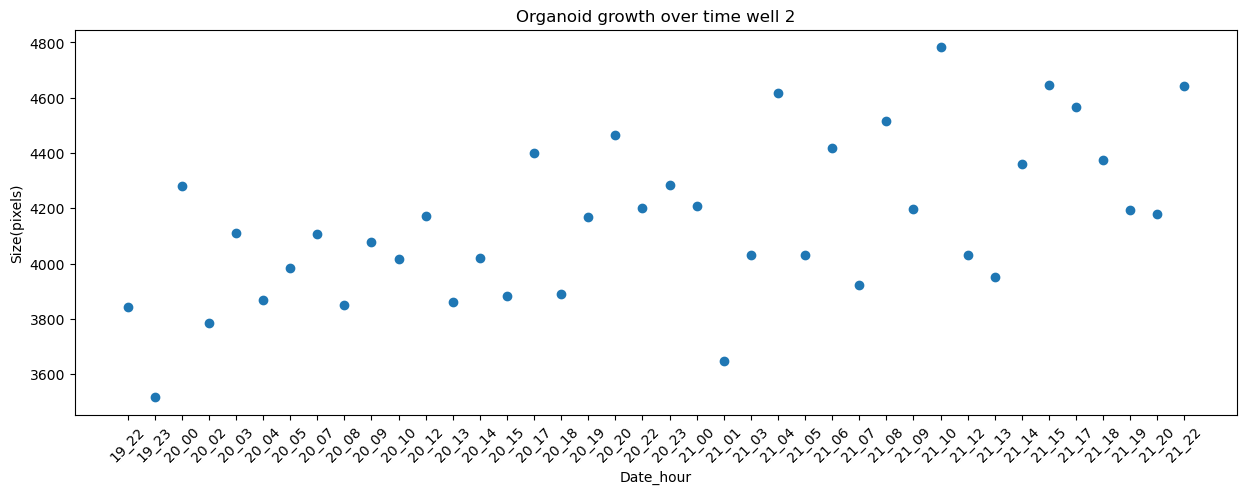

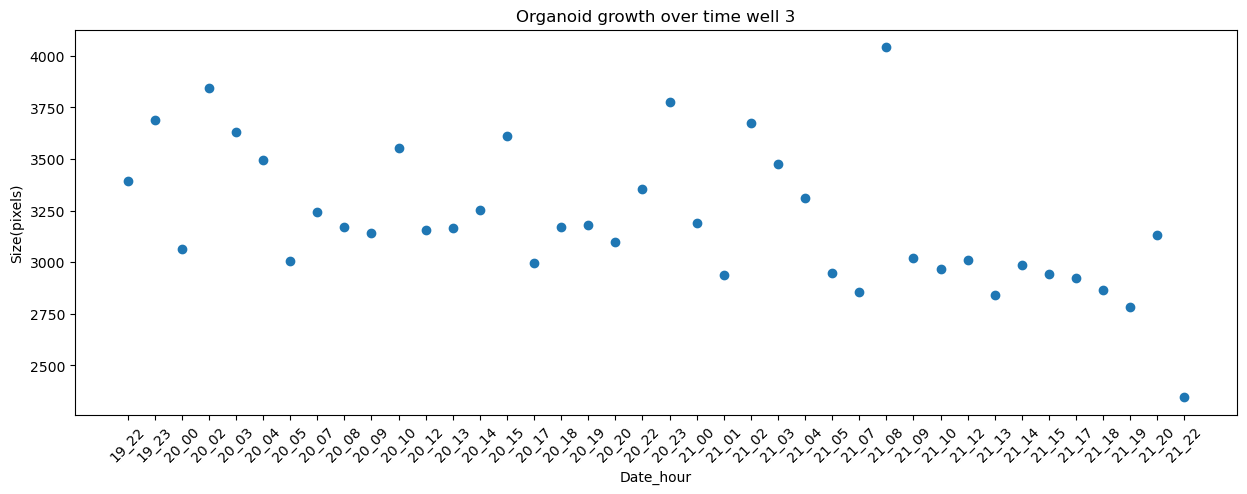

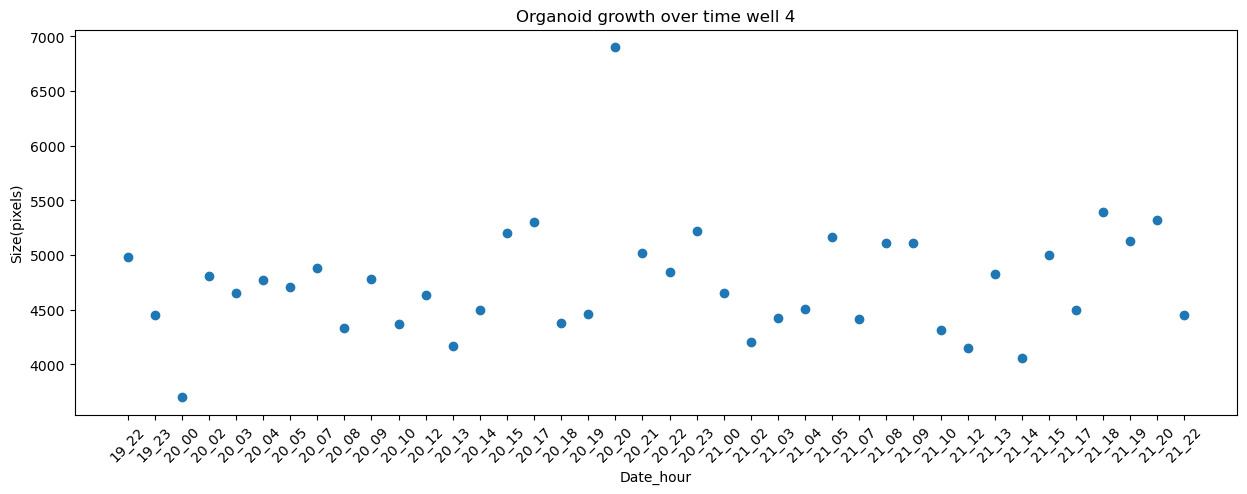

In [19]:
# Plotting 3 wells individually
def plot_scatter_one(well_dct):
    for k,v in well_dct.items():
        plt.figure(figsize = (15,5))
        plt.title(f"Organoid growth over time well {k}")
        plt.xlabel("Date_hour")
        plt.ylabel("Size(pixels)")
        plt.xticks(rotation = 45)
        plt.scatter(list(v.keys()), list(v.values()))
        plt.show()

plot_scatter_one(well_dct)